# **Importaciónes generales**
**Importamos paquetes necesarios y los datos de Fashion MNIST, tambien se definen algunas funciones básicas del plot de imágenes y la de rounded accuracy para las métricas**

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd


# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas importamos atplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
#Función para ver los resultados de las reconstrucciones en el modelo con 2 salidas
def show_reconstructions_class(model, images=X_test, n_images=5):
    reconstructions,_ = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
#Función para visualziar multiples imagenes generadas por las GANs o VAEs        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Sección 2.2**

2.2.1 Autoencoder regularizado usando redes convolucionales

**Definición y entrenamiento**

In [2]:
#Seed para evitar el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)
#Early stop por si es necesario
#Early_stop=keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=3,verbose=1,restore_best_weights=True,start_from_epoch=150)
#definimos el tamaño del batch
batch=64

#Definicion del encoder con convolucionales 
conv_encoder = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Reshape([28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dense(128,activation="relu")
])

#Definición del decoder con convolucionales
conv_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[3, 3, 128]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

#Definicion de la red autoencoder combinando el enconder y decoder ya definidos
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

#Se compila y entrena el modelo
conv_ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=[rounded_accuracy])

#Clear session para evitar que se guarde el entrenamiento por cada corrida del codigo
keras.backend.clear_session()
history = conv_ae.fit(X_train, X_train, batch,epochs=300,
                      validation_data=(X_valid, X_valid))#,callbacks=[Early_stop])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3, 3, 128)      │         8,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,064 (125.25 KB)

 Trainable params: 31,840 (124.38 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/300


I0000 00:00:1722975446.615534      84 service.cc:145] XLA service 0x7d30f4002450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722975446.615592      84 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1722975446.615596      84 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 32/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.5757 - rounded_accuracy: 0.4991 

I0000 00:00:1722975464.228142      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


860/860 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 4.1152 - rounded_accuracy: 0.6425 - val_loss: 1.3768 - val_rounded_accuracy: 0.7999
Epoch 2/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0220 - rounded_accuracy: 0.8866 - val_loss: 0.4245 - val_rounded_accuracy: 0.7687
Epoch 3/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3201 - rounded_accuracy: 0.9106 - val_loss: 0.1999 - val_rounded_accuracy: 0.7992
Epoch 4/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1560 - rounded_accuracy: 0.9272 - val_loss: 0.1252 - val_rounded_accuracy: 0.8846
Epoch 5/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1038 - rounded_accuracy: 0.9354 - val_loss: 0.0871 - val_rounded_accuracy: 0.9154
Epoch 6/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0749 - rounded_accuracy: 0.9387 - val_loss: 0.0638 - val_rounded_accuracy: 0.9230
Epoch 7/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0545 - rounded_accuracy: 0.9405 - val_loss: 0.0449 - val_rounded_accuracy: 0.

**Evolución del loss y accuracy**

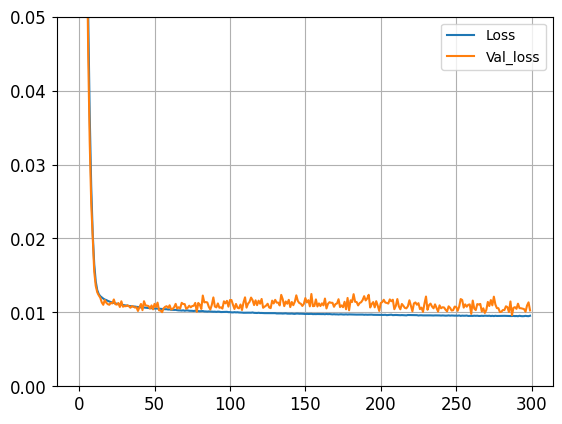

In [3]:
#Graficamos el loss de entrenamiento y de validación

plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0,0.05)
plt.legend()
plt.show()

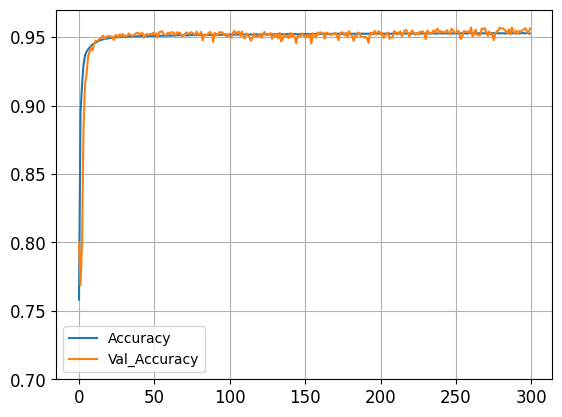

In [4]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy")
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0.7,0.97)
plt.legend()
plt.show()

**Predicción y Visualización de resultados**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


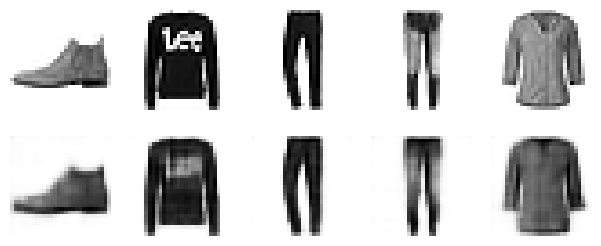

In [5]:
#Usando la función definida se hace una predicción y se visualiza
show_reconstructions(conv_ae)
plt.show()

**Discusión**

* Los valores y convergencia del loss y accuracy son bastante satisfactorios, lo que se puede observar bien en las imagenes de la reconstrucción comparadas con las originales.

* La elección de la función de perdida es relevante, mse funciona mejor que binary cross entropy en este caso ya que las reconstrucciones son directas, diferente al caso del modelo variacional donde las reconstruciones se hacen con densidades de probabildad en el espacio latente.

* Las gráficas de evolución del loss y accuracy muestran pocas fluctuaciones y una buena tendencia a la convergencia, lo que me lleva a resaltar una buena elección del optimizador y el learning rate.

* Tambíen probé con el pooling, cambiando de maxpooling a averagepooling, pero el resultado fue mejor en maxpooling, asi que en este caso favorece más el valor máximo que el promedio.

* Parámetros como el stride o el kernel size tambien pueden modificarse pero son más limitados por el tamaño requerido de las imagenes en el output, trate de modificarlo pero el mejor resultado fue siempre con kernel=3 y stride=2, cambiarlos dejando el mismo tamaño de output solo empeora el resultado de salida.

* Respecto a los tips de entrenamiento se pueden resaltar varias cosas:

    1. Si ubiera seguido con el optimizador SGD se podian ver resultados aceptables casi sin emplear ningún tip, y tampoco daba señales de overfitting, pero al cambiar a Adam los resultados sin emplear tips de entrenamiento eran muy malos, y SGD requeria un learning rate muy alto para converger a un resultado aceptable en menos de 300 epocas, tardando demasiado en la ejecución.
    2. Utilizando inicializadores y batch normalization Adam ya llegaba a algo, aunque seguia lejos de ser bueno, al menos se podía ver algun resultado de la predición, con mucho loss y poco accuracy.
    3. Ajustando el learning rate a un número inferior a 0.01, y utilizando regularizadores y dropout, pude darle 300 epocas a Adam para lograr el resultado final sin riesgo de overfitting. Lo más importante de esto fue el learning rate, con SGD un learning rate de 0.001 necesitaria unas 500 epocas para llegar al resultado que alcanzo Adam, pero sin los regularizadores ni el dropout el resulado no era bueno y corría riesgo de overfitting.
 
* Al final, con un loss de menos de 0.009 y un accuracy de más de 0.95, quedo conforme con el resultado del entrenamiento de la red.


2.2.2 Autoencoder Variacional

**Definición y Entrenamiento**

In [10]:
#Es importante definir la funcion de sampling que usa las salidas del enconder para regularizar el espacio latente con divergencia KL
@tf.function
def sampling(inputs):
    mean, log_var = inputs
    eps = K.random_normal(shape=tf.shape(mean))
    z = mean + K.exp(0.5*log_var) * eps
    return z

In [11]:
#Definimos una funcion para crear el encoder con la API funcional
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = keras.layers.RandomFlip(mode="horizontal")(encoder_inputs)
    x = keras.layers.RandomContrast(factor=0.2)(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

#Definimos la función que crea el decoder con la API funcional
def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*64, activation='relu')(decoder_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

#Esta clase se crea para introducir las propiedades del autoencode variacional, en particular el loss probabilistico
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, alpha=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha #Este parametro se usara para darle peso a la regularizacion con el loss KL
        
#La funcion call de la clase VAE calcula el loss por divergencia Kl usando los datos de salida del encoder, y luego los añade
#usado el metrodo add_loss
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = self.alpha * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    
#Esta funcion se usa en la función call para convertir las muestras del espacio latente en un conjunto continuo y diferenciable, y asi 
#el espacio latente se convierte en la nube de probabilidad
    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

#Para poder usar el parametro de escalado y darle pesos a los diferentes loss creamos una clase para un loss custom escalado
class ScaledBinaryCrossentropy:
    #la funcion init para inicializar el factor de escalada
    def __init__(self, scale=1.0):
        self.scale = scale
        
    #En la funcion call se calcula la perdida escalada y la retorna
    def __call__(self, y_true, y_pred):
        # Calcula la binary crossentropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Retorna la binary crossentropy escalada
        return self.scale * bce

In [14]:
#Como voy a poner muchas epocas, prefiero definir una funcion para hacer learning rate scheduling por si es necesario
#Define el learning rate basado en la epoca
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

In [17]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 10
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Usamos la clase VAE para definir el modelo
vae = VAE(encoder, decoder)
#Se crea el callback para el learning rate scheduling
piecewise_constant_fn = piecewise_constant([100,200,300], [0.1, 0.01, 0.005,0.001])
#scheduler=keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

#Definimos los pesos que llevaran los loss
alpha = 0.4
beta= 1-alpha
#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

Model: "vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ?                      │       423,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ ?                      │        90,561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,877 (1.96 MB)

 Trainable params: 513,493 (1.96 MB)

 Non-trainable params: 384 (1.50 KB)

In [18]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae.fit(X_train, X_train, epochs=200, batch_size=32, validation_data=(X_valid, X_valid))#,callbacks=[scheduler])

Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.3380 - rounded_accuracy: 0.7075 - val_loss: 0.2566 - val_rounded_accuracy: 0.8413
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2128 - rounded_accuracy: 0.8869 - val_loss: 0.2158 - val_rounded_accuracy: 0.8839
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2030 - rounded_accuracy: 0.8996 - val_loss: 0.2106 - val_rounded_accuracy: 0.8929
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2001 - rounded_accuracy: 0.9034 - val_loss: 0.2070 - val_rounded_accuracy: 0.8968
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1982 - rounded_accuracy: 0.9063 - val_loss: 0.2074 - val_rounded_accuracy: 0.8936
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1970 - rounded_accuracy: 0.9079 - val_loss: 0.2010 - val_rounded_accuracy: 0.9041
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1960 - rounded_accuracy: 0.9096 - val_loss: 0.2046 -

**Evolución del loss y el accuracy**

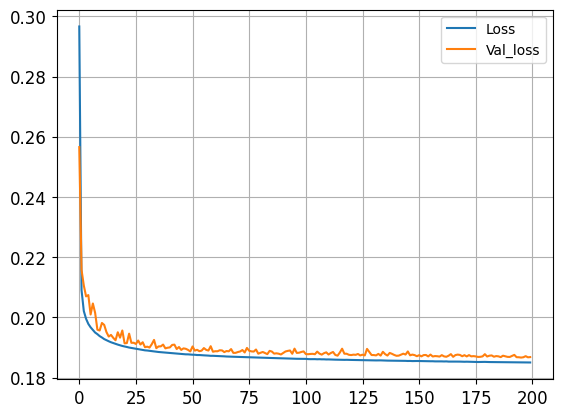

In [20]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

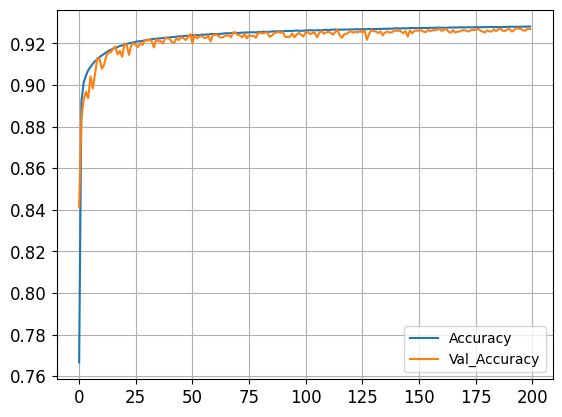

In [22]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy")
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.7,0.75)
plt.legend()
plt.show()

**Predicción y visualización de resultados**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


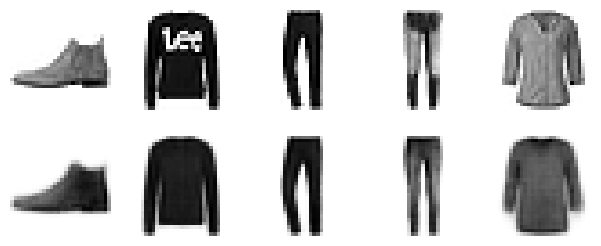

In [23]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae)
plt.show()

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


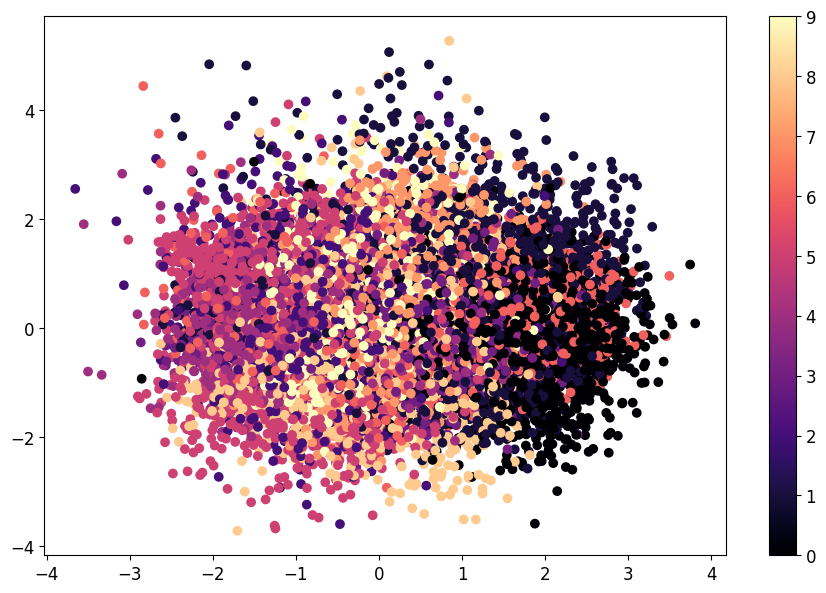

In [25]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


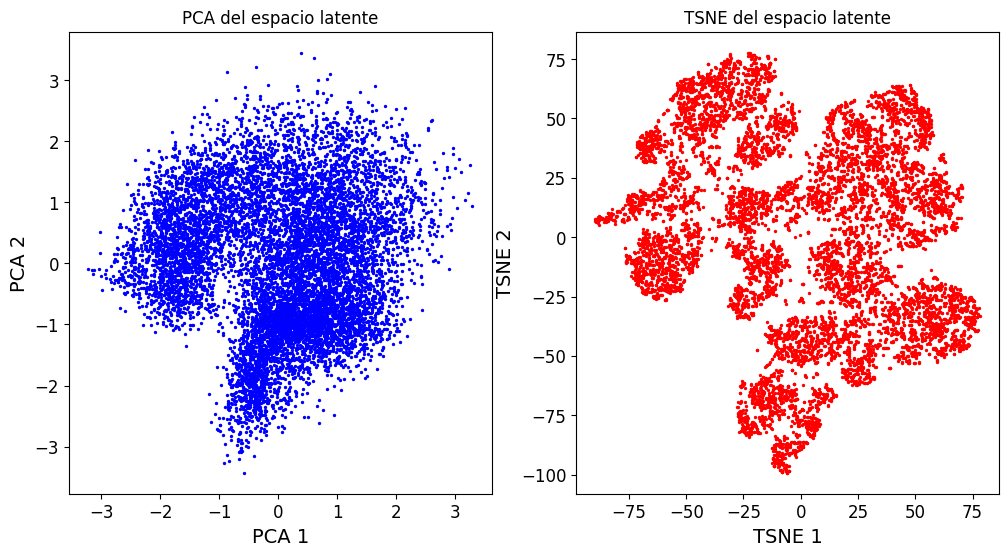

In [28]:
#Para revisar el espacio latente usamos PCA y TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extraer los valores latentes
z_mean, _ = vae.encoder.predict(X_test)

# Aplicar PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Aplicar TSNE
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z_mean)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# PCA
plt.subplot(1, 2, 1)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c='blue', s=2)
plt.title('PCA del espacio latente')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# TSNE
plt.subplot(1, 2, 2)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='red', s=2)
plt.title('TSNE del espacio latente')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

plt.show()

**Discusión**
* La principal diferencia entre el modelo variacional y el autoncoder regular esta en la distribucion del espacio latente, en lugar de usar distancias y puntos precisos trata de crear una distribucion uniforme que permita samplear datos desde el espacio latente. Esto abre la puerta a la generacion de uevos datos  que combinan las caracteristicas aprendidas por la red.
* La arquitectura en este caso fue fundamentalmente diferente a la  usada en el caso del modelo no variacional, se observa sobre todo la falta de regularizacion por dropout o las normas l1,l2. Esto es porque se le esta relegando toda la regularizacion a la divergencia KL.
* Las redes variacionales presentan una elevada sensibilidad, esto debido a que la divergencia KL es bastante inestable. Es de aqui que surge el no regularizar de mas el modelo y permitir que el espacio latente sea regido unicamente por la divergencia KL.
* Es escencialmente un modelo con 2 funciones loss, y esto genera una especie de comptencia entre la regularizacion del espacio latente (KL) y la calidad de las reconstrucciones (en este caso crossentropia binaria).
* Dentro del marco de la competencia, darle mucha prevalencia a un loss sobre el otro puede voltear la balanza muy a favor de alguna de las 2 tareas. Si la KL es muy dominante la regularizacion del espacio latente sera buena pero perderemos calidad de reconstruccion, mientras que si domina la crossentropia mejorara la recosntruccion a costa de empeorar la regularizacion del espacio latente.
* Otro factor determiante en el conflicto reularizacion-reconstruccion es la dimension final del espacio latente. Una dimension grande permite mejores reconstrucciones al poder recolectar muchas mas caracteristicas, pero se vuelve imposible de regularizar. Una dimension pequeña es muy regular y el espacio latente se asemejara mucho a una gaussiana, pero las reconstrucciones seran peores al no poder recolectar buenas caracteristicas. Es clave entonces definir un equilibrio en este aspecto.
* La función de costo es dferente al modelo no variacional. Al usar distribuciones de probabilidad y no puntos exactos del esapcio latente, es mucho mejor la crossentropia binaria comparada con un MSE. La crossentropia esta optimizada para trabajar con probabilidades.   
* El optimizador me parece un caso curioso, si bien SGD normalmente es un optimizador de pruebas ya que suele ser lento y requerir learning rates altos.  Pero dada la sensibilidad e inestabilidad de  la funcion de costo KL, fue favorable el uso de SGD por sobre Adam (que es mas inestable) para evitar problemas de gradient vanishing o gradient exploding que no peritian entrenar el modelo satisfactoriamente.

2.2.3 GANs

**Toda esta sección se aloja en un cuaderno aparte con el fin de destinarle todos los recursos de ese cuaderno al ser un modelo tan exigente**

**Discusión**
* Este modelo es increiblemente pesado de ejecutar. Consume tantos recursos que lo máximo que me permite la RAM de kaggle son 10 epocas y tengo que reiniciar l sesión porque la RAM queda llena y no se como vaciarla.
* El problema de ejecutar pocas epocas es que no hay mucho margen para ver la mejora del modelo y los tiempos de ejecución siempre son muy elevados, 

# Sección 2.3
**Clasificación y GradCAM+++**

**Nuevas librerias y funciones necesarias**

In [ ]:
#La primera vez tuve que instalar el paquete de vis, aunque ahora esta configurado para guardarse en el entorno, es mejor dejarlo aqui por si algo
#!pip install tf-keras-vis tensorflow --target=/kaggle/working/

In [29]:
#importamos las librerias de vis par usar GradCAM++
import tf_keras_vis 
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

#importamos la matriz de confuson para ver el resultado de la clasificación
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#Definimos una función para graficar la matriz de confusion
def show_classification(model, images=X_test):
    classification,_=model.predict(images)
    cm=confusion_matrix(y_test,classification.argmax(axis=1),normalize="true")
    disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax)

#Esta parte solo muestra cuantas GPUs reconoce tensorflow
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 2 GPUs


Pruebas CAMS con VAE


In [16]:
#Vamos a utilizar todo lo definido anteriormente de la VAE para crear una nueva VAE que tambien clasifique
#Primero definimos una funcion para crear las capas del clasificador con densas
def build_classifier(class_num,latent_dim):
    classifier_input =  tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Flatten()(classifier_input)
    x = tf.keras.layers.Dense(500,name="First_class_layer",activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(200,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    classifier_output = tf.keras.layers.Dense(class_num,activation="softmax",name="class_output")(x)
    classifier= tf.keras.Model(classifier_input,classifier_output,name="Classifier")
    return classifier
    
#Tambien vamos a crear una clase hija a la clase vae para añadir el parametro de classificador pero sin modificar lo demás
class VAE_classifier(tf.keras.Model):
    def __init__(self, encoder, decoder,classifier,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        classification = self.classifier(z)
        return classification
    
    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

In [37]:
latent_dim = 2
class_num = 10
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
classifier = build_classifier(class_num,latent_dim)
#Usamos la clase VAE para definir el modelo
classificator = VAE_classifier(encoder, decoder,classifier)
#Se crea el callback para el learning rate scheduling
piecewise_constant_fn = piecewise_constant([100,200,300], [0.1, 0.01, 0.005,0.001])
#scheduler=keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
#Compilamos
classificator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy",metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [38]:
#Entrenamos
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=classificator.fit(X_train,y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid))#,callbacks=[scheduler])

Epoch 1/50


/kaggle/working/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['bias', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


860/860 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 368.2756 - sparse_categorical_accuracy: 0.0988 - val_loss: 16.6541 - val_sparse_categorical_accuracy: 0.0994
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 13.1252 - sparse_categorical_accuracy: 0.0982 - val_loss: 6.5776 - val_sparse_categorical_accuracy: 0.0994
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.7869 - sparse_categorical_accuracy: 0.0981 - val_loss: 4.4672 - val_sparse_categorical_accuracy: 0.0994
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.3552 - sparse_categorical_accuracy: 0.0981 - val_loss: 4.1963 - val_sparse_categorical_accuracy: 0.0994
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.1989 - sparse_categorical_accuracy: 0.0977 - val_loss: 4.1884 - val_sparse_categorical_accuracy: 0.0994
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.1917 - sparse_categorical_accuracy: 0.0973 - val_loss: 4.1898 - val_sparse_categorical_accuracy: 0.0994
Epoch 7/5

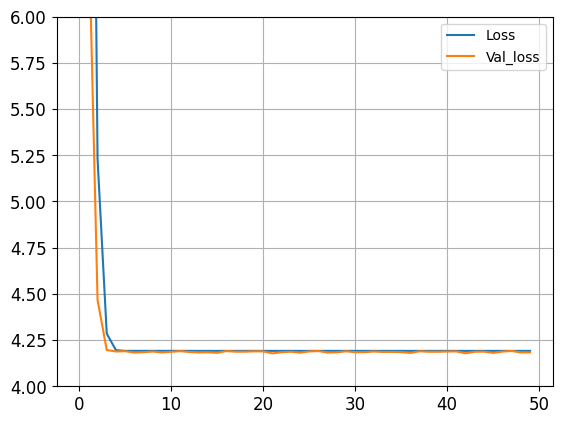

In [39]:
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(4,6)
plt.legend()
plt.show()

In [35]:
plt.plot(history.history["accuracy"],label="Accuracy")
plt.plot(history.history["val_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,0.05)
plt.legend()
plt.show()

KeyError: 'accuracy'

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


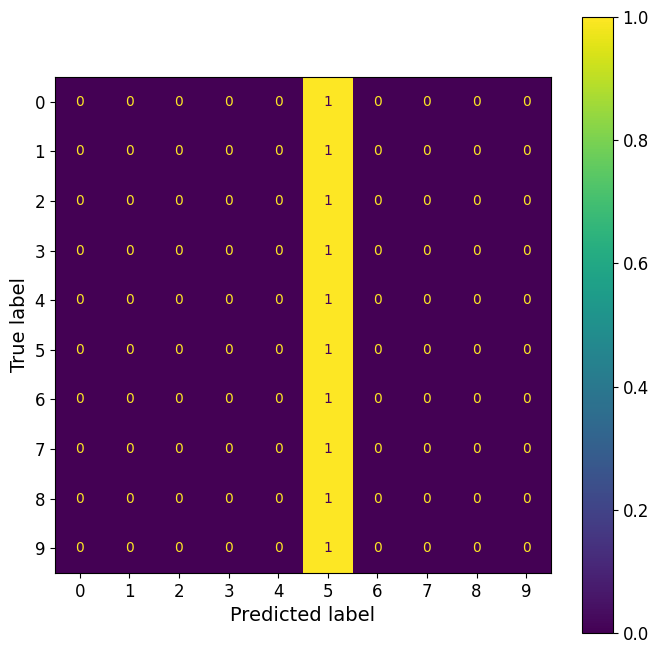

In [40]:
#Visualizamos la clasificación en predicción usando la matriz de confusion
show_classification(classificator)

**Modelo con clasificación**

In [34]:
#Antes de crear la instancia GradCAM++ es necesario definir el modelo con clasificación que se va a evaluar

#Seed para evitar el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)

#Número de clases para clasificar y batch size
class_num=10
batch=64

#Definimos una red que solo va a clasificar las imagenes de fashion mnist
#La primera sección se compone de las capas convolucionales que van a extraer las caracteristicas de las imagenes
input_layer = keras.layers.Input(shape=[28,28])
x = keras.layers.Reshape([28,28,1])(input_layer)
x = keras.layers.Conv2D(16, name="Conv1",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(32,name="Conv2", kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
#x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(32, name="Conv3",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(64, name="Conv4",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
#x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(64, name="Conv5",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
latent_space = keras.layers.MaxPool2D(pool_size=2)(x)
#A partir de este punto siguen las capas densas que utilizan las caracteristicas extraidas para definir a que clase
#pertenecen las imagenes
class_input = keras.layers.Flatten()(latent_space)
x = keras.layers.Dense(500,name="First_class_layer",activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(class_input)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(200,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
class_output = keras.layers.Dense(class_num,activation="softmax",name="class_output")(x)
#Tambien añadimos una seccion de reconstruccion para regularizar
decoder_input = keras.layers.Conv2DTranspose(32,name="Convtrans1", kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(latent_space)
x = keras.layers.Dropout(rate=0.1)(decoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(16,name="Convtrans2", kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(1,name="Convtrans3", kernel_size=3, strides=2, padding="SAME", activation="sigmoid")(x)
decoder_output = keras.layers.Reshape([28, 28])(x)

#Definimos el modelo usando la api funcional y lo compilamos, al final mostramos el resumen del modelo o un diagrama 
classifier = keras.Model(inputs=input_layer,outputs=[class_output,decoder_output])
classifier.compile(loss=["sparse_categorical_crossentropy","binary_crossentropy"],optimizer=keras.optimizers.Adam(0.0001),metrics=["sparse_categorical_accuracy","accuracy"])
#classifier.summary()
#tf.keras.utils.plot_model(classifier,show_layer_names=True,dpi=50)

In [52]:
#Se entrena el modelo
history = classifier.fit(X_train,y_train, batch,epochs=300,
                      validation_data=(X_valid,y_valid))

Epoch 1/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - class_output_sparse_categorical_accuracy: 0.9171 - loss: 0.3933 - val_class_output_sparse_categorical_accuracy: 0.9174 - val_loss: 0.3883
Epoch 2/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - class_output_sparse_categorical_accuracy: 0.9183 - loss: 0.3915 - val_class_output_sparse_categorical_accuracy: 0.9234 - val_loss: 0.3824
Epoch 3/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - class_output_sparse_categorical_accuracy: 0.9186 - loss: 0.3933 - val_class_output_sparse_categorical_accuracy: 0.9168 - val_loss: 0.3979
Epoch 4/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - class_output_sparse_categorical_accuracy: 0.9173 - loss: 0.3996 - val_class_output_sparse_categorical_accuracy: 0.9174 - val_loss: 0.3903
Epoch 5/300
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - class_output_sparse_categorical_accuracy: 0.9181 - loss: 0.3939 - val_class_output_sparse_categorical_accuracy: 0.9050 - val_loss: 0.4096
Epoch 6/300
860/860 ━━━━━━━━━━━━━━━

**Visualizacion del loss y el accuracy**


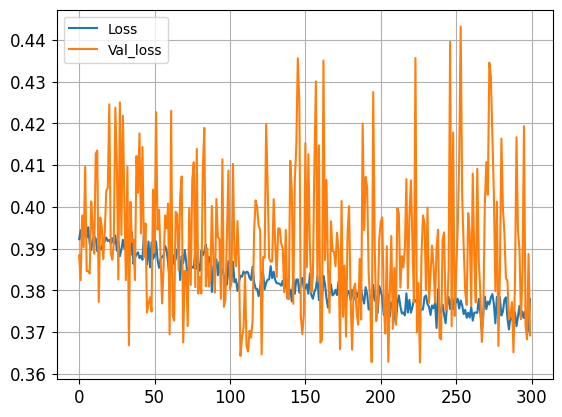

In [54]:
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#lt.ylim(0.3,0.75)
plt.legend()
plt.show()

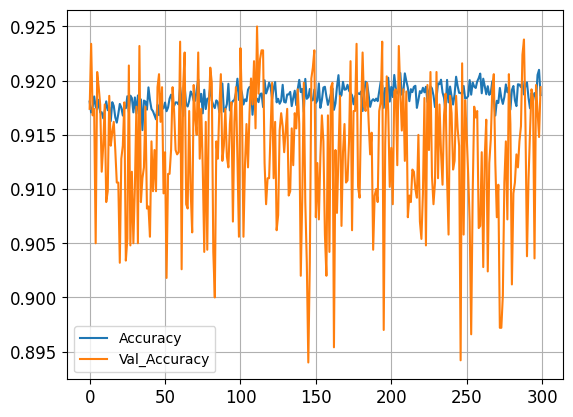

In [55]:
plt.plot(history.history["class_output_sparse_categorical_accuracy"],label="Accuracy")
plt.plot(history.history["val_class_output_sparse_categorical_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,0.05)
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


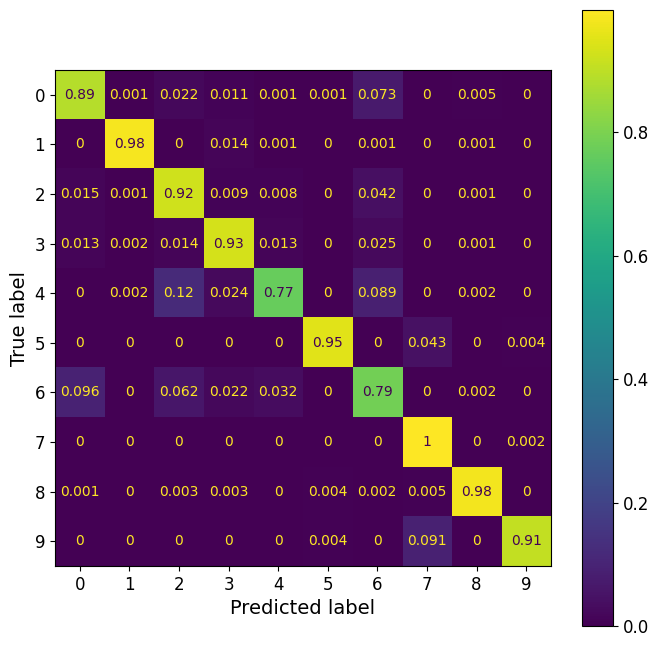

In [56]:
#Visualizamos la clasificación en predicción usando la matriz de confusion
show_classification(classifier)

**Implementación del GradCAM++**

**Pasos previos**

Creacion de variables y prueba

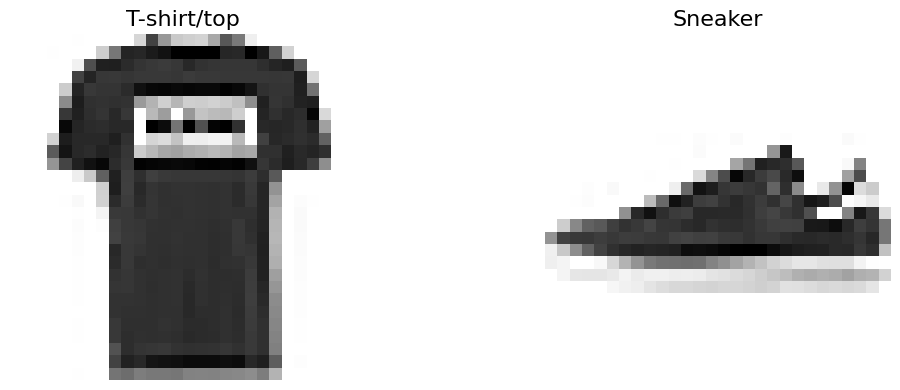

In [43]:
#Lo primero es definir las imagenes que se van a clasificar
#Les ponemos un título
img_titles=["T-shirt/top","Sneaker"]

#Dejo por acá porque es importante la lista con las clases y sus indices en fashion MNIST
classes=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

#Extraemos las imagenes que queremos clasificar
index_1 = None
for i, label in enumerate(y_train):
    if label == 0:  # Definimos el indice de la clase que queremos verificar, en este caso revisare la peor y mejor clasificada
        index_1 = i
        break

# y guardamos la imagen en una variable
if index_1 is not None:
    image_1 = X_train[index_1]

#Igual para la otra clase
index_2 = None
for i, label in enumerate(y_train):
    if label == 7:  # La otra clase que vamos a verificar
        index_2 = i
        break

# y guardamos la imagen en una variable
if index_2 is not None:
    image_2 = X_train[index_2]

#Las imagenes ya estaban normalizadas, pero por conveniencia mejor centrarlas en 0
image_1=np.array(image_1*2-1)

image_2=np.array(image_2*2-1)


#Creamos un arreglo de numpy con las imagenes
images = np.array([image_1,image_2])

# visualizamos las imagenes que vamos a utilizar
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(img_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap="binary")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Definición del objeto GradCAM++**

**Otras funciones clave**

In [48]:
#Replace to linear se usa para cambiar la activacion de la capa que se vaya a visualizar a una linear que es 
#la que debe usarse para que los maps funcionen correctamente
replace2linear = ReplaceToLinear()

#Es necesario definir un modelo parcial de 1 sola salida para usar con el CAM
partial = keras.Model(inputs=classifier.input,outputs=classifier.get_layer("class_output").output)
# Definimos el objeto gradcam
gradcam = GradcamPlusPlus(partial,model_modifier=replace2linear,clone=True)

#Creamos una funcion que permita crear los heatmaps en secuencia para ver como las imagenes se relacionan con cada una de las diferentes clases
#y asi reutilizarla para ver los Cams en las 3 capas diferentes

def generate_cams(img_titles,classes,gradcam,images,conv_layer):
    lcam_ = []
    lcamN_= []
    for i in range(len(img_titles)):
        for j in range(len(classes)):
            score =  CategoricalScore(j)
            #Este paso es el que crea el objeto cam que luego se transforma en el heatmap
            cam = gradcam(score,
                  images[i],  normalize_cam = False,
                  penultimate_layer= conv_layer#Este es el parametro que define que capa vamos a visualizar
                           )
        # Guardamos los cams creados en una lista para mostarlos luego
            lcam_.append(cam[0])
        #similar pero los cams normalizados   
            lcamN_.append(normalize(cam[0])) 
    return lcam_ ,lcamN_

#Definimos la funcion para plotear las cams ya creadas
def plot_heatmaps(lcamN_,img_titles,classes,images,Sub_title):
    # Para visualizar las imagenes y el mapa de calor se crea un for que va a plotear
    # todas las imagenes generadas tanto del vestido como del bolso
    f, ax = plt.subplots(nrows=2, ncols=10, figsize=(22, 6))
    for i, title in enumerate(img_titles):
        for j in range(len(classes)):
            if i==0:
                heatmap = np.uint8(mpl.cm.jet(lcamN_[j])[..., :3] * 255)
                #heatmap = heatmap[0]
                ax[i][j].set_title(title + " vs "+ classes[j], fontsize=16)
                ax[i][j].imshow(images[i])
                ax[i][j].imshow(heatmap, cmap='jet', alpha=0.5)
                ax[i][j].axis('off')
            else:    
                heatmap = np.uint8(mpl.cm.jet(lcamN_[j+10])[..., :3] * 255)
                #heatmap = heatmap[0]
                ax[i][j].set_title(title + " vs "+classes[j], fontsize=16)
                ax[i][j].imshow(images[i])
                ax[i][j].imshow(heatmap, cmap='jet', alpha=0.5)
                ax[i][j].axis('off')
    plt.suptitle(Sub_title,fontsize=16)            
    plt.tight_layout()
    plt.show()

**Para la primera capa convolucional**

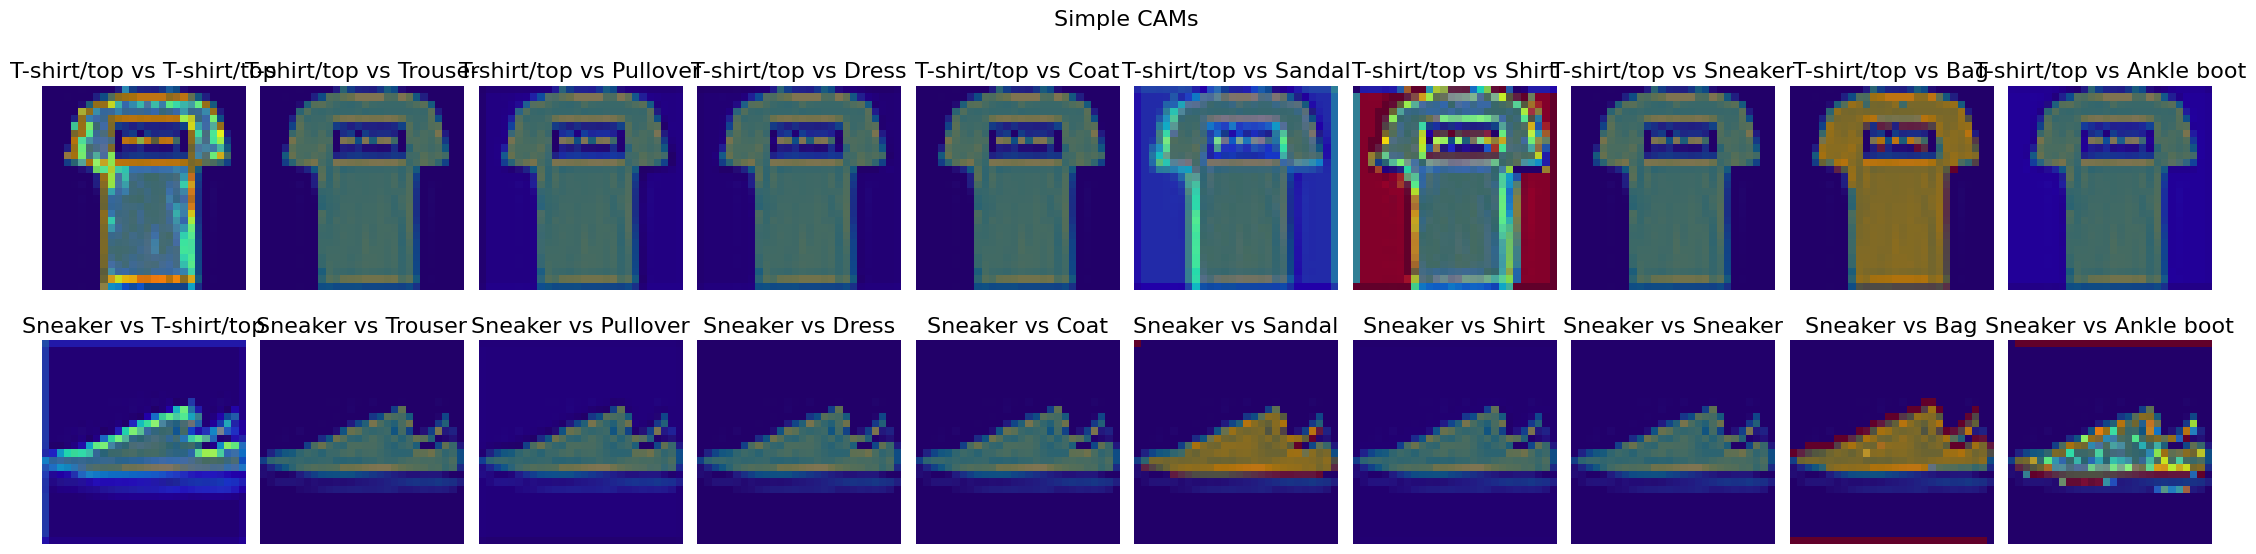

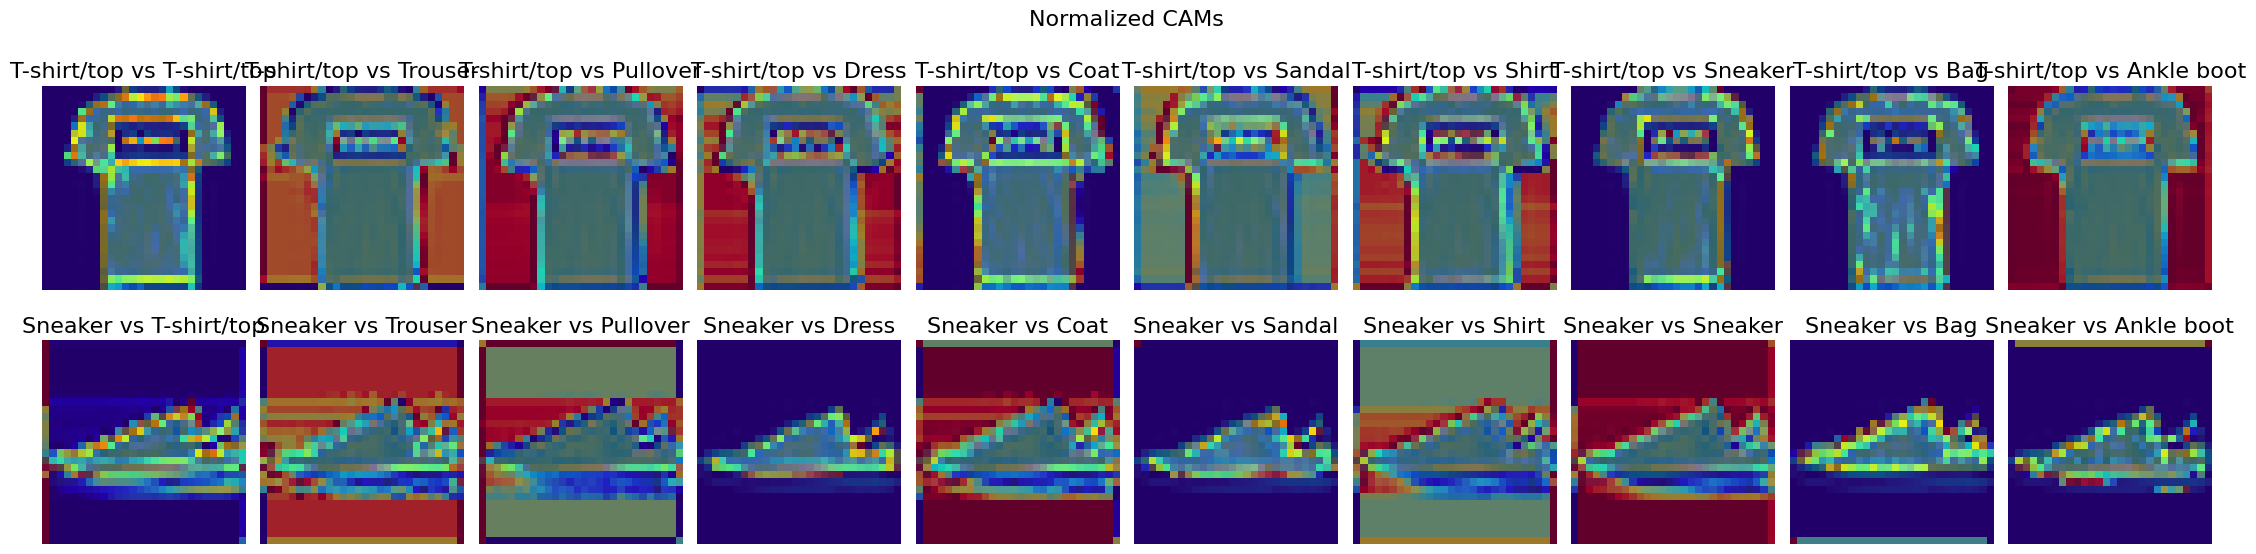

In [49]:
lcam_,lcamN_= generate_cams(img_titles,classes,gradcam,images,"Conv1")
plot_heatmaps(lcam_,img_titles,classes,images,"Simple CAMs")

plot_heatmaps(lcamN_,img_titles,classes,images,"Normalized CAMs")

**Para la segunda capa**

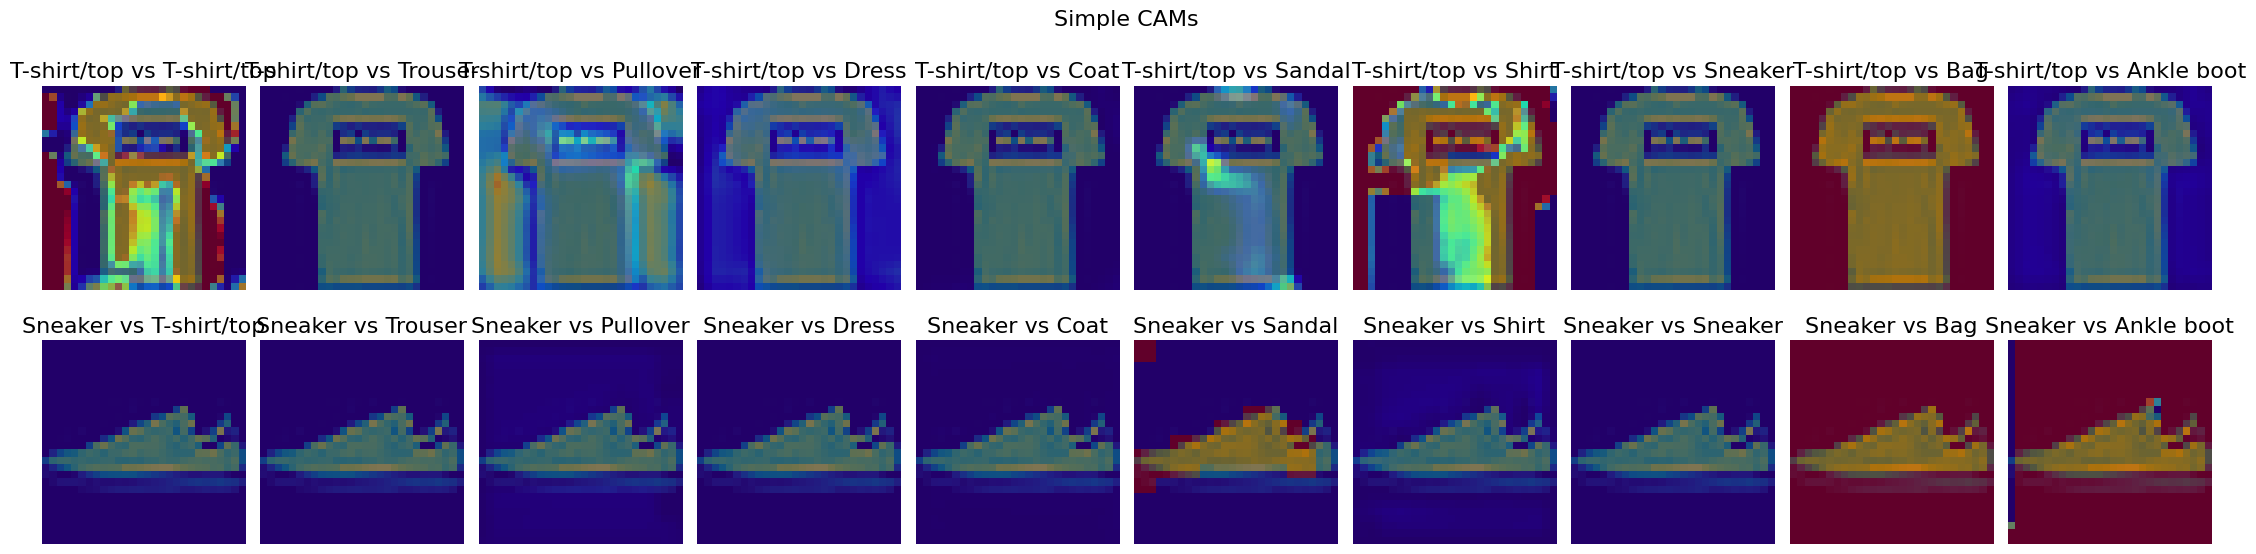

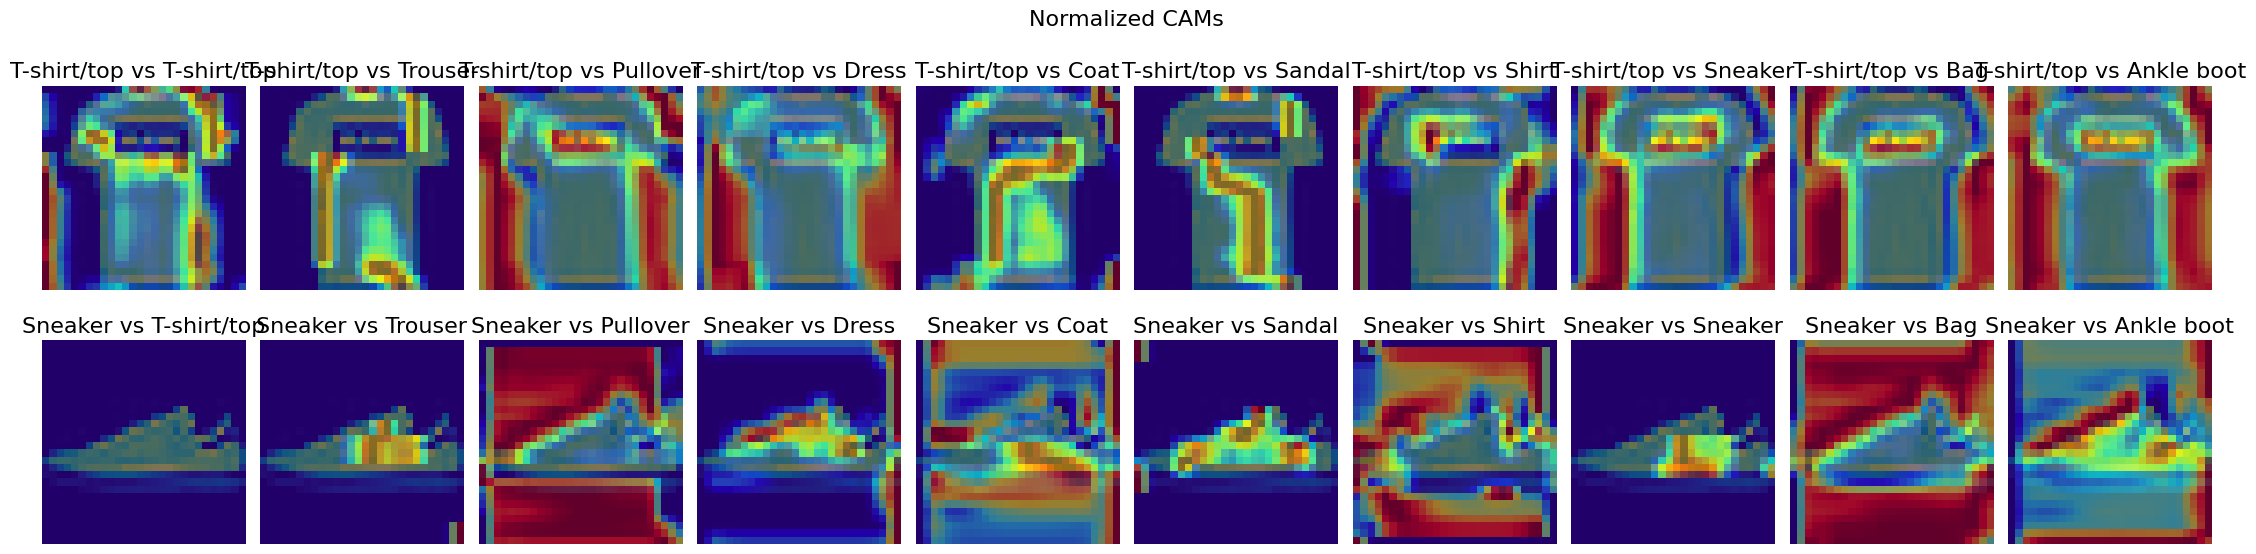

In [50]:
lcam_,lcamN_= generate_cams(img_titles,classes,gradcam,images,"Conv3")
plot_heatmaps(lcam_,img_titles,classes,images,"Simple CAMs")

plot_heatmaps(lcamN_,img_titles,classes,images,"Normalized CAMs")

**para la tercera capa**

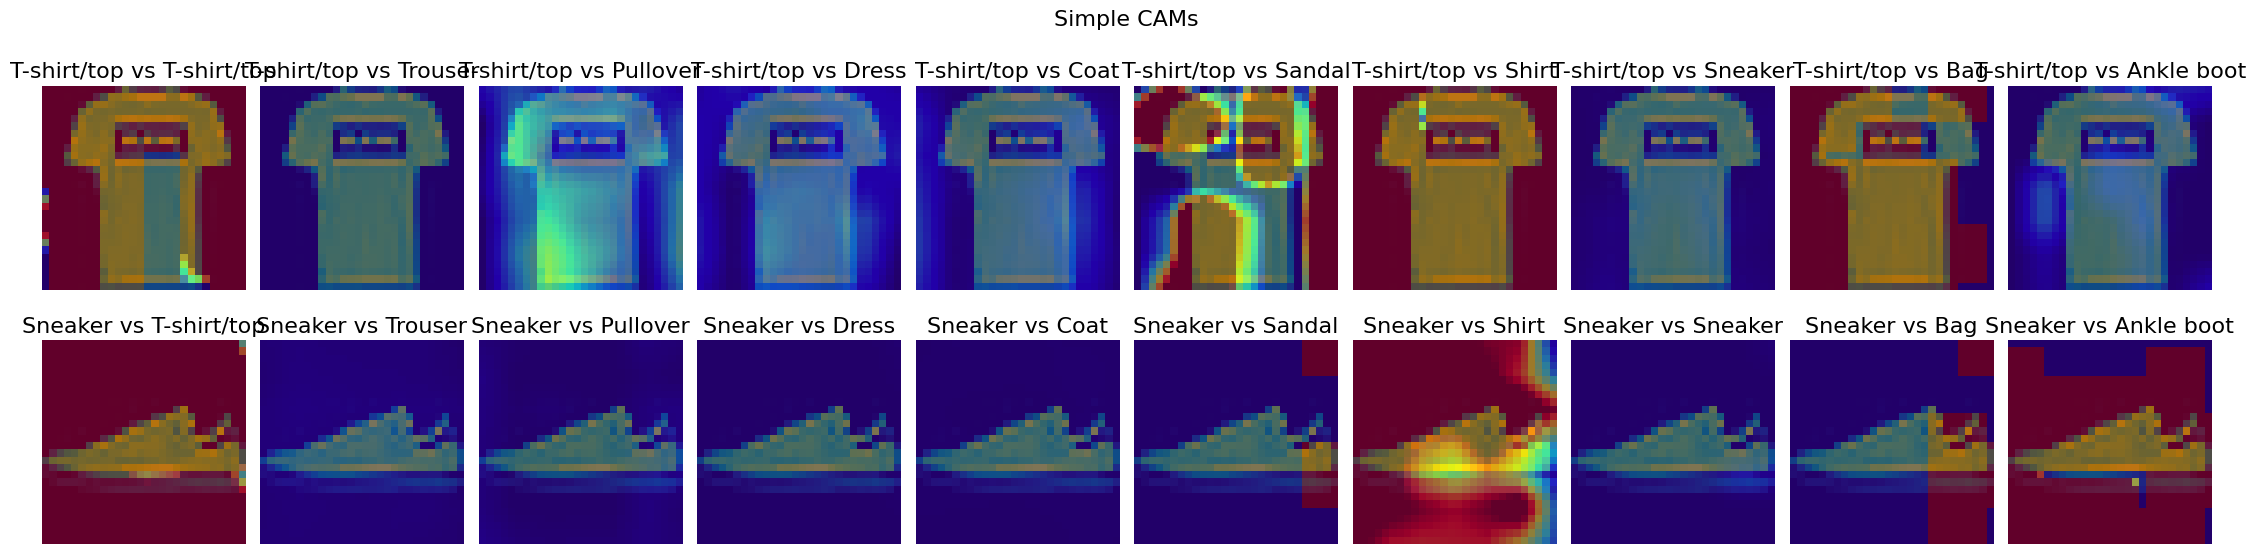

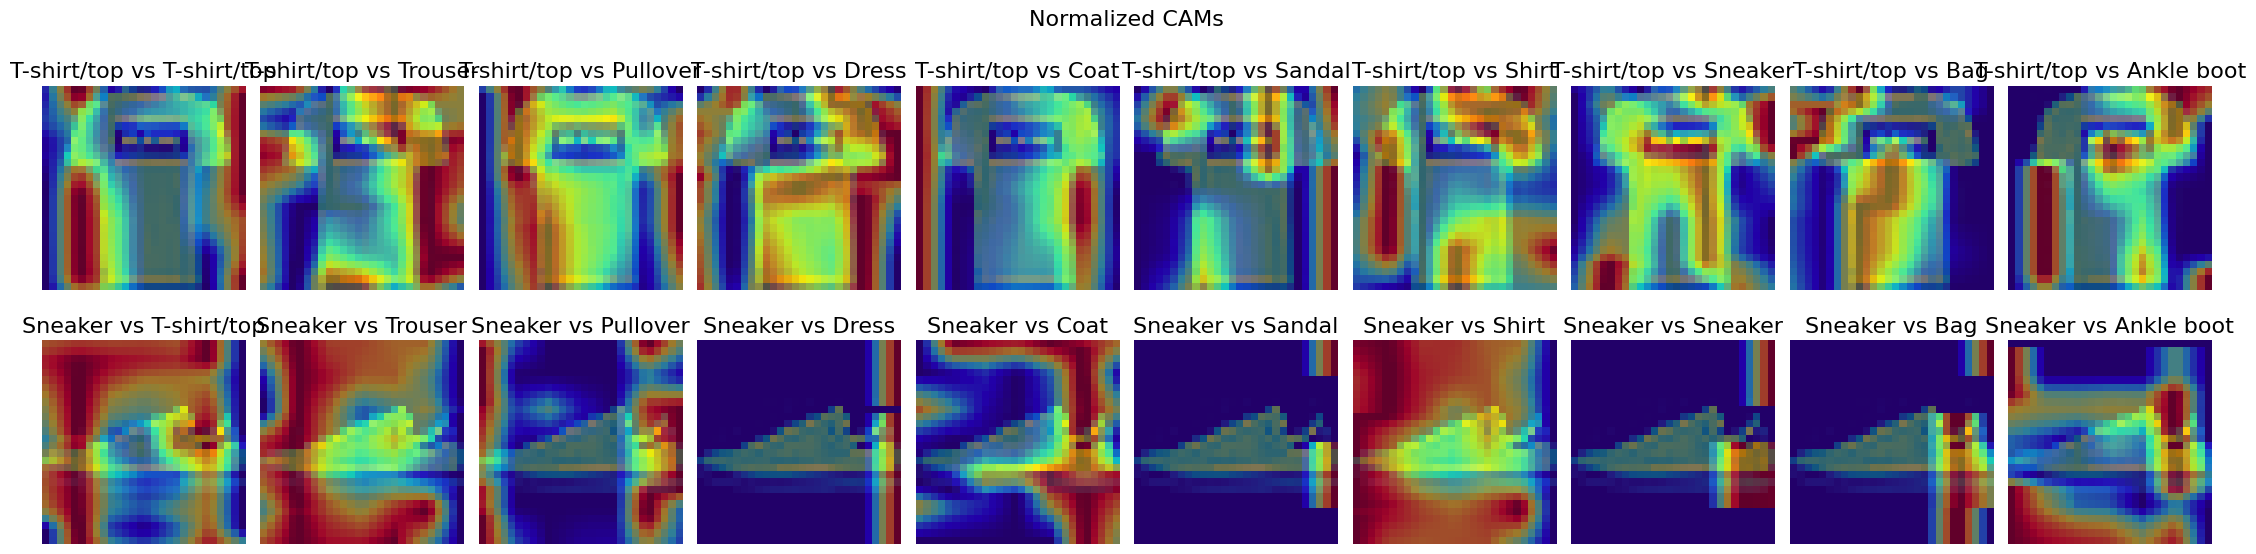

In [51]:
lcam_,lcamN_= generate_cams(img_titles,classes,gradcam,images,"Conv5")
plot_heatmaps(lcam_,img_titles,classes,images,"Simple CAMs")

plot_heatmaps(lcamN_,img_titles,classes,images,"Normalized CAMs")

## Seccion 2.4
**Deepfake**